In [1]:
import sys
import os, sys, tarfile
import numpy as np
import matplotlib.pyplot as plt
import urllib
from PIL import Image
from keras.optimizers import RMSprop, SGD

from keras.models import load_model
import keras.backend as K
import data_preprocessing, data_generator, visual, label_parser, data_postprocessing, evaluator
import pdb
import tensorflow as tf

#os.environ["CUDA_VISIBLE_DEVICES"]="1"

config = tf.ConfigProto()    #to limit TensorFlow resources
config.gpu_options.allow_growth = True
tf.Session(config = config)

%matplotlib inline

%load_ext autoreload
%autoreload 2

C:\Users\Vital\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TEST_PATH = '../udacity_driving_datasets/'
test_ann = label_parser.parse_annotation_json(TEST_PATH, 'labels_val.json')
print("len(test_ann) = ", len(test_ann))

len(test_ann) =  833


In [3]:
size = 300
config_test  = {'grid_w':9, 'grid_h':9, 'img_w' : size, 'img_h' : size, 'is_augment' : False, 'batch_size' : len(test_ann)}
GRID_W = config_test['grid_w']
GRID_H = config_test['grid_h']
input_w = config_test['img_w']
input_h = config_test['img_h']
testGenerator = data_generator.BatchGenerator(test_ann, config_test)

iteration_num =  1


In [4]:
import tensorflow as tf
def YOLO_loss(y_true, y_pred):
    mask_obj = K.expand_dims(y_true[..., 0], axis=-1)
    mask_no_obj = 1 - mask_obj
    loss_obj = K.sum(K.square(y_true-y_pred)*mask_obj)                             #Loss_xywhp for object
    loss_no_obj = K.sum(K.square(y_true[...,0]-y_pred[...,0])*mask_no_obj[...,0] ) #only confidence
    N_obj = tf.reduce_sum(tf.to_float(mask_obj > 0.0))
    N_no_obj = tf.reduce_sum(tf.to_float(mask_no_obj > 0.0))
    return loss_obj / (N_obj + 1e-06) + 5 * loss_no_obj / (N_no_obj + 1e-06)       #because only 1 from 5 values (p,x,y,w,h)

In [5]:
from keras.utils.generic_utils import get_custom_objects
from keras.models import load_model
get_custom_objects().update({"YOLO_loss": YOLO_loss})
model = load_model("model_udacity_aug_30_30_ap_0_495.h5", custom_objects={ 'loss': YOLO_loss } )

In [6]:
def add_chunk(indices, y_GT, y_pred):
    x_chunk, y_chunk = testGenerator.get_XY(indices)
    y_GT += [y_chunk]
    y_pred += [model.predict(x_chunk)]
y_GT   = []
y_pred = []                         # we add to 'y_pred' data by chunk because of memory limitation
chunk_size = 50                     # we get 'chunk_size' images and forward pass the model on them
N = len(test_ann)                   # images number for to evaluaet mAP
num_of_chunk = int(N / chunk_size)
for i in range(num_of_chunk):
    indices = np.array(range(i*chunk_size, (i+1)*chunk_size))
    add_chunk(indices, y_GT, y_pred)
    print("predicted images (" + str(i*chunk_size) + " - " + str((i+1)*chunk_size) + ")")
if num_of_chunk * chunk_size < N:
    indices = np.array(range(num_of_chunk * chunk_size, N ))
    add_chunk(indices, y_GT, y_pred)
    print("predicted images (" + str(num_of_chunk * chunk_size) + " - " + str(N) + ")")

predicted images (0 - 50)
predicted images (50 - 100)
predicted images (100 - 150)
predicted images (150 - 200)
predicted images (200 - 250)
predicted images (250 - 300)
predicted images (300 - 350)
predicted images (350 - 400)
predicted images (400 - 450)
predicted images (450 - 500)
predicted images (500 - 550)
predicted images (550 - 600)
predicted images (600 - 650)
predicted images (650 - 700)
predicted images (700 - 750)
predicted images (750 - 800)
predicted images (800 - 833)


In [7]:
#merge chunks to shape : y[i] = output
y_pred_reshaped = np.zeros((N, GRID_W, GRID_H, 4+1) )
y_GT_reshaped = np.zeros( (N, GRID_W, GRID_H, 4+1) )
y_pred = np.array(y_pred)
y_GT = np.array(y_GT)
last_ind = 0
for i in range(len(y_pred)): 
    size = len(y_pred[i])  
    y_pred_reshaped[last_ind:last_ind+size] = y_pred[i][:]
    y_GT_reshaped[last_ind:last_ind+size] = y_GT[i][:]
    last_ind += size

In [8]:
y_pred_reshaped.shape

(833, 9, 9, 5)

In [9]:
decoder = data_postprocessing.Decoder(GRID_W, GRID_H, input_w, input_h, 0.0)
pred_rects_decoded, scores = decoder.decode(y_pred_reshaped)
GT_rects_decoded  = decoder.decode_GT(y_GT_reshaped)

In [10]:
scores[3]

array([1.18151319, 1.16818988, 0.98703754, 0.79096222, 0.68515342,
       0.60312468, 0.49143302, 0.18269908, 0.11899633, 0.07104944])

In [11]:
pred_boxes = {}
gt_boxes = {}
for i in range(len(scores) ):
    pred_boxes[str(i)] = {}
    pred_boxes[str(i)]['boxes'] = pred_rects_decoded[i]
    pred_boxes[str(i)]['scores'] = scores[i]
    gt_boxes[str(i)] = GT_rects_decoded[i]
    
res = evaluator.get_avg_precision_at_iou(gt_boxes,pred_boxes, 0.5)
ap = res['avg_prec']
prec = res['precisions']
recall = res['recalls']
print("ap = %.3f"%ap)

Prediction box is malformed? pred box: [141.6667138536771, -18.60555112361908, 118.488372862339, 0.6197402874628715]
Prediction box is malformed? pred box: [141.6667138536771, -18.60555112361908, 118.488372862339, 0.6197402874628715]
Prediction box is malformed? pred box: [-10.425736506779987, 250.03929684559503, -23.483779033025105, 253.362471361955]
Prediction box is malformed? pred box: [182.66012966632843, 273.1783896684647, 171.77988390127817, 297.0273862282436]
Prediction box is malformed? pred box: [182.66012966632843, 273.1783896684647, 171.77988390127817, 297.0273862282436]
Prediction box is malformed? pred box: [210.36758174498874, 19.131940603256226, 221.70203775167462, 17.54261056582133]
Prediction box is malformed? pred box: [210.36758174498874, 19.131940603256226, 221.70203775167462, 17.54261056582133]
Prediction box is malformed? pred box: [210.36758174498874, 19.131940603256226, 221.70203775167462, 17.54261056582133]
Prediction box is malformed? pred box: [210.367581744

Prediction box is malformed? pred box: [243.2826926310857, 258.2878249386946, 251.1908799409866, 253.68819857637084]
Prediction box is malformed? pred box: [243.2826926310857, 258.2878249386946, 251.1908799409866, 253.68819857637084]
Prediction box is malformed? pred box: [40.99843502044678, 268.65154206752777, 57.799311478932694, 252.7428279320399]
Prediction box is malformed? pred box: [40.99843502044678, 268.65154206752777, 57.799311478932694, 252.7428279320399]
Prediction box is malformed? pred box: [110.12098118662834, 53.551749885082245, 94.37841400504112, 38.173977037270866]
Prediction box is malformed? pred box: [110.12098118662834, 53.551749885082245, 94.37841400504112, 38.173977037270866]
Prediction box is malformed? pred box: [110.12098118662834, 53.551749885082245, 94.37841400504112, 38.173977037270866]
Prediction box is malformed? pred box: [42.98256536324819, 275.49394716819126, 55.210794011751815, 260.6857324639956]
Prediction box is malformed? pred box: [42.982565363248

In [13]:
indices = np.array(range(20))
x_batch, y_batch = testGenerator.get_XY(indices)   
decoder = data_postprocessing.Decoder(GRID_W, GRID_H, input_w, input_h, 0.5)
GT_rects_to_show  = decoder.decode_GT(y_batch)
pred_rects_to_show, scores_to_show = decoder.decode(y_batch)

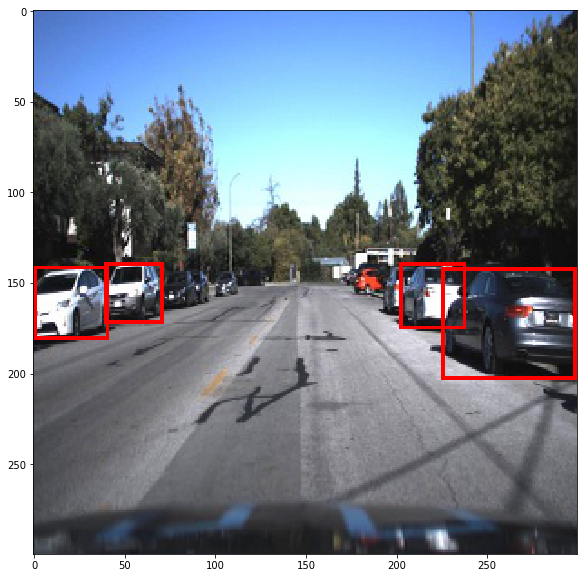

In [18]:
img_num = 3
test_image = x_batch[img_num]*255.0
GT_rects = GT_rects_to_show[img_num]
pred_rects =  rects_to_show[img_num]
plt.rcParams['figure.figsize'] = 10, 10

plt.imshow(visual.draw_image_pred_GT(test_image, rects_pred = pred_rects) )
#plt.imshow(visual.draw_image_pred_GT(test_image, GT_rects, pred_rects) )
# plt.imshow(visual.draw_image_pred_GT(test_image, GT_rects) )

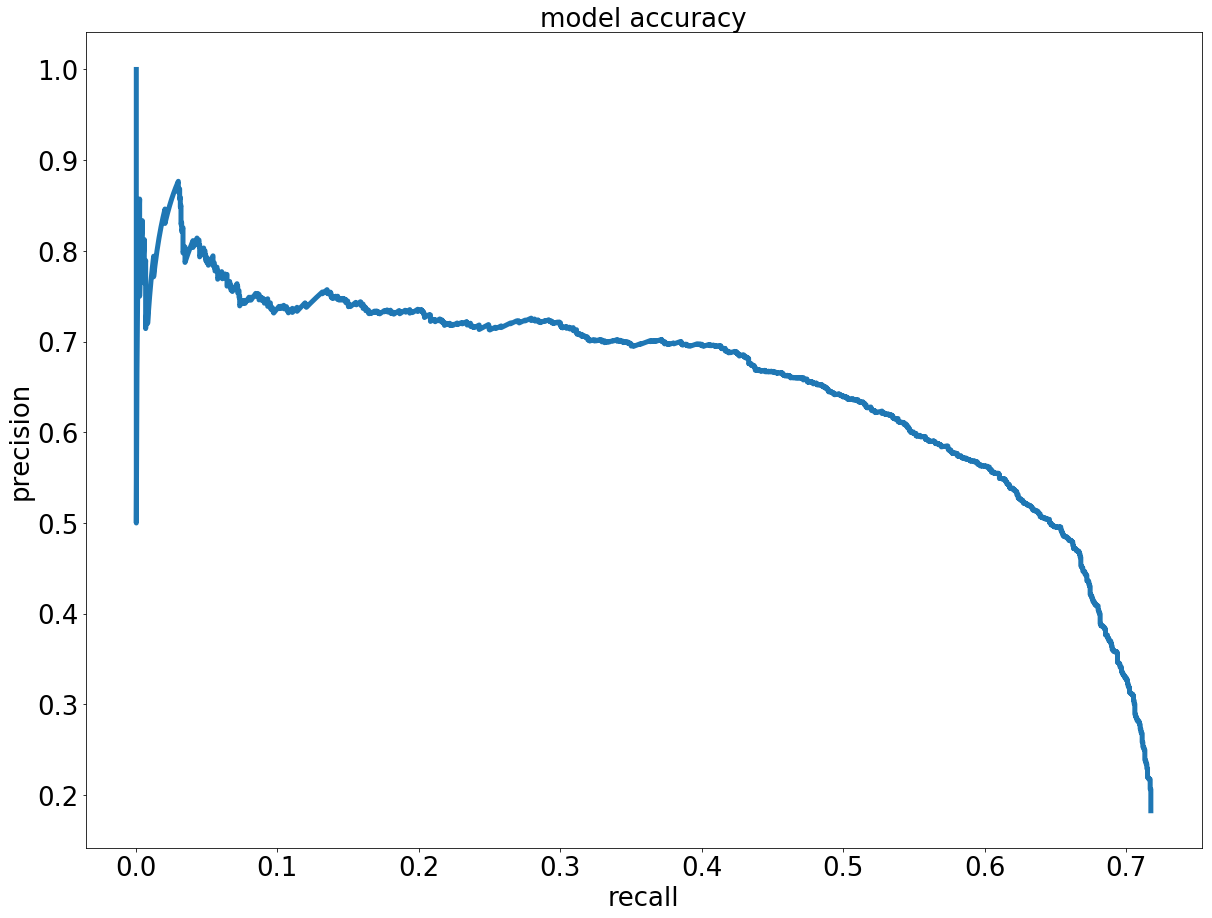

In [19]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 20, 15
plt.rcParams['lines.markersize'] = 30
plt.rcParams['lines.linewidth'] = 5

fig, ax = plt.subplots()

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
    
# summarize history for accuracy   
plt.plot(recall, prec)
plt.title('model accuracy', fontsize = 26)
plt.ylabel('precision', fontsize = 26)
plt.xlabel('recall', fontsize = 26)
plt.show()
